# Input (welch)

## pacu

In [59]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
from scipy.signal import welch

### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수




input_path = 'dataset/preprocess3/input3-2/welch/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_2min/'
    ecg_path = '../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_2min/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/preprocess3/input3/df_preprocess_pacu','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test', 'rb'))
    caseid_train = pickle.load(open('caseid_train', 'rb'))
    caseid_val = pickle.load(open('caseid_val', 'rb'))
    

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        
        # 한 NRS에 대해 23개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000
                
                # input의 normalization
                pleth_inp = ppg_per_NRS[start_idx:end_idx]
                pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                ecg_inp = ecg_per_NRS[start_idx:end_idx]
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                
                
                welch_ppg, welch_ecg = [], []
                # 1초맏 welch 적용
                for j in range(LEN_INPUT):
                    welch_ppg.append(welch(pleth_inp[j*250:(j+1)*250],SRATE)[1])
                    welch_ecg.append(welch(ecg_inp[j*250:(j+1)*250],SRATE)[1])
                
                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu.append([welch_ppg, welch_ecg])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    x_val_pacu.append([welch_ppg, welch_ecg])
                    y_val_pacu.append(int(float(row['NRS'])))
                    
                else:
                    x_train_pacu.append([welch_ppg, welch_ecg])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)
    x_val_pacu = np.array(x_val_pacu, np.float32)
    y_val_pacu = np.array(y_val_pacu, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'x_val_pacu.npz', x_val_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    np.savez_compressed(input_path+'y_val_pacu.npz', y_val_pacu)
    print('done', flush=True)

    
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of validation set(pacu):', len(x_val_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/7316 ...completed
loading data 2/7316 ...

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


completed
loading data 3/7316 ...completed
loading data 4/7316 ...completed
loading data 5/7316 ...completed
loading data 6/7316 ...completed
loading data 7/7316 ...completed
loading data 8/7316 ...completed
loading data 9/7316 ...completed
loading data 10/7316 ...completed
loading data 11/7316 ...completed
loading data 12/7316 ...completed
loading data 13/7316 ...completed
loading data 14/7316 ...completed
loading data 15/7316 ...completed
loading data 16/7316 ...completed
loading data 17/7316 ...completed
loading data 18/7316 ...completed
loading data 19/7316 ...completed
loading data 20/7316 ...completed
loading data 21/7316 ...completed
loading data 22/7316 ...completed
loading data 23/7316 ...completed
loading data 24/7316 ...completed
loading data 25/7316 ...completed
loading data 26/7316 ...completed
loading data 27/7316 ...completed
loading data 28/7316 ...completed
loading data 29/7316 ...completed
loading data 30/7316 ...completed
loading data 31/7316 ...completed
loading dat

loading data 241/7316 ...completed
loading data 242/7316 ...completed
loading data 243/7316 ...completed
loading data 244/7316 ...completed
loading data 245/7316 ...completed
loading data 246/7316 ...completed
loading data 247/7316 ...completed
loading data 248/7316 ...completed
loading data 249/7316 ...completed
loading data 250/7316 ...completed
loading data 251/7316 ...completed
loading data 252/7316 ...completed
loading data 253/7316 ...completed
loading data 254/7316 ...completed
loading data 255/7316 ...completed
loading data 256/7316 ...completed
loading data 257/7316 ...completed
loading data 258/7316 ...completed
loading data 259/7316 ...completed
loading data 260/7316 ...completed
loading data 261/7316 ...completed
loading data 262/7316 ...completed
loading data 263/7316 ...completed
loading data 264/7316 ...completed
loading data 265/7316 ...completed
loading data 266/7316 ...completed
loading data 267/7316 ...completed
loading data 268/7316 ...completed
loading data 269/731

loading data 476/7316 ...completed
loading data 477/7316 ...completed
loading data 478/7316 ...completed
loading data 479/7316 ...completed
loading data 480/7316 ...completed
loading data 481/7316 ...completed
loading data 482/7316 ...completed
loading data 483/7316 ...completed
loading data 484/7316 ...completed
loading data 485/7316 ...completed
loading data 486/7316 ...completed
loading data 487/7316 ...completed
loading data 488/7316 ...completed
loading data 489/7316 ...completed
loading data 490/7316 ...completed
loading data 491/7316 ...completed
loading data 492/7316 ...completed
loading data 493/7316 ...completed
loading data 494/7316 ...completed
loading data 495/7316 ...completed
loading data 496/7316 ...completed
loading data 497/7316 ...completed
loading data 498/7316 ...completed
loading data 499/7316 ...completed
loading data 500/7316 ...completed
loading data 501/7316 ...completed
loading data 502/7316 ...completed
loading data 503/7316 ...completed
loading data 504/731

loading data 711/7316 ...completed
loading data 712/7316 ...completed
loading data 713/7316 ...completed
loading data 714/7316 ...completed
loading data 715/7316 ...completed
loading data 716/7316 ...completed
loading data 717/7316 ...completed
loading data 718/7316 ...completed
loading data 719/7316 ...completed
loading data 720/7316 ...completed
loading data 721/7316 ...completed
loading data 722/7316 ...completed
loading data 723/7316 ...completed
loading data 724/7316 ...completed
loading data 725/7316 ...completed
loading data 726/7316 ...completed
loading data 727/7316 ...completed
loading data 728/7316 ...completed
loading data 729/7316 ...completed
loading data 730/7316 ...completed
loading data 731/7316 ...completed
loading data 732/7316 ...completed
loading data 733/7316 ...completed
loading data 734/7316 ...completed
loading data 735/7316 ...completed
loading data 736/7316 ...completed
loading data 737/7316 ...completed
loading data 738/7316 ...completed
loading data 739/731

loading data 945/7316 ...completed
loading data 946/7316 ...completed
loading data 947/7316 ...completed
loading data 948/7316 ...completed
loading data 949/7316 ...completed
loading data 950/7316 ...completed
loading data 951/7316 ...completed
loading data 952/7316 ...completed
loading data 953/7316 ...completed
loading data 954/7316 ...completed
loading data 955/7316 ...completed
loading data 956/7316 ...completed
loading data 957/7316 ...completed
loading data 958/7316 ...completed
loading data 959/7316 ...completed
loading data 960/7316 ...completed
loading data 961/7316 ...completed
loading data 962/7316 ...completed
loading data 963/7316 ...completed
loading data 964/7316 ...completed
loading data 965/7316 ...completed
loading data 966/7316 ...completed
loading data 967/7316 ...completed
loading data 968/7316 ...completed
loading data 969/7316 ...completed
loading data 970/7316 ...completed
loading data 971/7316 ...completed
loading data 972/7316 ...completed
loading data 973/731

loading data 1177/7316 ...completed
loading data 1178/7316 ...completed
loading data 1179/7316 ...completed
loading data 1180/7316 ...completed
loading data 1181/7316 ...completed
loading data 1182/7316 ...completed
loading data 1183/7316 ...completed
loading data 1184/7316 ...completed
loading data 1185/7316 ...completed
loading data 1186/7316 ...completed
loading data 1187/7316 ...completed
loading data 1188/7316 ...completed
loading data 1189/7316 ...completed
loading data 1190/7316 ...completed
loading data 1191/7316 ...completed
loading data 1192/7316 ...completed
loading data 1193/7316 ...completed
loading data 1194/7316 ...completed
loading data 1195/7316 ...completed
loading data 1196/7316 ...completed
loading data 1197/7316 ...completed
loading data 1198/7316 ...completed
loading data 1199/7316 ...completed
loading data 1200/7316 ...completed
loading data 1201/7316 ...completed
loading data 1202/7316 ...completed
loading data 1203/7316 ...completed
loading data 1204/7316 ...co

loading data 1406/7316 ...completed
loading data 1407/7316 ...completed
loading data 1408/7316 ...completed
loading data 1409/7316 ...completed
loading data 1410/7316 ...completed
loading data 1411/7316 ...completed
loading data 1412/7316 ...completed
loading data 1413/7316 ...completed
loading data 1414/7316 ...completed
loading data 1415/7316 ...completed
loading data 1416/7316 ...completed
loading data 1417/7316 ...completed
loading data 1418/7316 ...completed
loading data 1419/7316 ...completed
loading data 1420/7316 ...completed
loading data 1421/7316 ...completed
loading data 1422/7316 ...completed
loading data 1423/7316 ...completed
loading data 1424/7316 ...completed
loading data 1425/7316 ...completed
loading data 1426/7316 ...completed
loading data 1427/7316 ...completed
loading data 1428/7316 ...completed
loading data 1429/7316 ...completed
loading data 1430/7316 ...completed
loading data 1431/7316 ...completed
loading data 1432/7316 ...completed
loading data 1433/7316 ...co

loading data 1634/7316 ...completed
loading data 1635/7316 ...completed
loading data 1636/7316 ...completed
loading data 1637/7316 ...completed
loading data 1638/7316 ...completed
loading data 1639/7316 ...completed
loading data 1640/7316 ...completed
loading data 1641/7316 ...completed
loading data 1642/7316 ...completed
loading data 1643/7316 ...completed
loading data 1644/7316 ...completed
loading data 1645/7316 ...completed
loading data 1646/7316 ...completed
loading data 1647/7316 ...completed
loading data 1648/7316 ...completed
loading data 1649/7316 ...completed
loading data 1650/7316 ...completed
loading data 1651/7316 ...completed
loading data 1652/7316 ...completed
loading data 1653/7316 ...completed
loading data 1654/7316 ...completed
loading data 1655/7316 ...completed
loading data 1656/7316 ...completed
loading data 1657/7316 ...completed
loading data 1658/7316 ...completed
loading data 1659/7316 ...completed
loading data 1660/7316 ...completed
loading data 1661/7316 ...co

loading data 1866/7316 ...completed
loading data 1867/7316 ...completed
loading data 1868/7316 ...completed
loading data 1869/7316 ...completed
loading data 1870/7316 ...completed
loading data 1871/7316 ...completed
loading data 1872/7316 ...completed
loading data 1873/7316 ...completed
loading data 1874/7316 ...completed
loading data 1875/7316 ...completed
loading data 1876/7316 ...completed
loading data 1877/7316 ...completed
loading data 1878/7316 ...completed
loading data 1879/7316 ...completed
loading data 1880/7316 ...completed
loading data 1881/7316 ...completed
loading data 1882/7316 ...completed
loading data 1883/7316 ...completed
loading data 1884/7316 ...completed
loading data 1885/7316 ...completed
loading data 1886/7316 ...completed
loading data 1887/7316 ...completed
loading data 1888/7316 ...completed
loading data 1889/7316 ...completed
loading data 1890/7316 ...completed
loading data 1891/7316 ...completed
loading data 1892/7316 ...completed
loading data 1893/7316 ...co

loading data 2095/7316 ...completed
loading data 2096/7316 ...completed
loading data 2097/7316 ...completed
loading data 2098/7316 ...completed
loading data 2099/7316 ...completed
loading data 2100/7316 ...completed
loading data 2101/7316 ...completed
loading data 2102/7316 ...completed
loading data 2103/7316 ...completed
loading data 2104/7316 ...completed
loading data 2105/7316 ...completed
loading data 2106/7316 ...completed
loading data 2107/7316 ...completed
loading data 2108/7316 ...completed
loading data 2109/7316 ...completed
loading data 2110/7316 ...completed
loading data 2111/7316 ...completed
loading data 2112/7316 ...completed
loading data 2113/7316 ...completed
loading data 2114/7316 ...completed
loading data 2115/7316 ...completed
loading data 2116/7316 ...completed
loading data 2117/7316 ...completed
loading data 2118/7316 ...completed
loading data 2119/7316 ...completed
loading data 2120/7316 ...completed
loading data 2121/7316 ...completed
loading data 2122/7316 ...co

loading data 2323/7316 ...completed
loading data 2324/7316 ...completed
loading data 2325/7316 ...completed
loading data 2326/7316 ...completed
loading data 2327/7316 ...completed
loading data 2328/7316 ...completed
loading data 2329/7316 ...completed
loading data 2330/7316 ...completed
loading data 2331/7316 ...completed
loading data 2332/7316 ...completed
loading data 2333/7316 ...completed
loading data 2334/7316 ...completed
loading data 2335/7316 ...completed
loading data 2336/7316 ...completed
loading data 2337/7316 ...completed
loading data 2338/7316 ...completed
loading data 2339/7316 ...completed
loading data 2340/7316 ...completed
loading data 2341/7316 ...completed
loading data 2342/7316 ...completed
loading data 2343/7316 ...completed
loading data 2344/7316 ...completed
loading data 2345/7316 ...completed
loading data 2346/7316 ...completed
loading data 2347/7316 ...completed
loading data 2348/7316 ...completed
loading data 2349/7316 ...completed
loading data 2350/7316 ...co

loading data 2550/7316 ...completed
loading data 2551/7316 ...completed
loading data 2552/7316 ...completed
loading data 2553/7316 ...completed
loading data 2554/7316 ...completed
loading data 2555/7316 ...completed
loading data 2556/7316 ...completed
loading data 2557/7316 ...completed
loading data 2558/7316 ...completed
loading data 2559/7316 ...completed
loading data 2560/7316 ...completed
loading data 2561/7316 ...completed
loading data 2562/7316 ...completed
loading data 2563/7316 ...completed
loading data 2564/7316 ...completed
loading data 2565/7316 ...completed
loading data 2566/7316 ...completed
loading data 2567/7316 ...completed
loading data 2568/7316 ...completed
loading data 2569/7316 ...completed
loading data 2570/7316 ...completed
loading data 2571/7316 ...completed
loading data 2572/7316 ...completed
loading data 2573/7316 ...completed
loading data 2574/7316 ...completed
loading data 2575/7316 ...completed
loading data 2576/7316 ...completed
loading data 2577/7316 ...co

loading data 2778/7316 ...completed
loading data 2779/7316 ...completed
loading data 2780/7316 ...completed
loading data 2781/7316 ...completed
loading data 2782/7316 ...completed
loading data 2783/7316 ...completed
loading data 2784/7316 ...completed
loading data 2785/7316 ...completed
loading data 2786/7316 ...completed
loading data 2787/7316 ...completed
loading data 2788/7316 ...completed
loading data 2789/7316 ...completed
loading data 2790/7316 ...completed
loading data 2791/7316 ...completed
loading data 2792/7316 ...completed
loading data 2793/7316 ...completed
loading data 2794/7316 ...completed
loading data 2795/7316 ...completed
loading data 2796/7316 ...completed
loading data 2797/7316 ...completed
loading data 2798/7316 ...completed
loading data 2799/7316 ...completed
loading data 2800/7316 ...completed
loading data 2801/7316 ...completed
loading data 2802/7316 ...completed
loading data 2803/7316 ...completed
loading data 2804/7316 ...completed
loading data 2805/7316 ...co

loading data 3007/7316 ...completed
loading data 3008/7316 ...completed
loading data 3009/7316 ...completed
loading data 3010/7316 ...completed
loading data 3011/7316 ...completed
loading data 3012/7316 ...completed
loading data 3013/7316 ...completed
loading data 3014/7316 ...completed
loading data 3015/7316 ...completed
loading data 3016/7316 ...completed
loading data 3017/7316 ...completed
loading data 3018/7316 ...completed
loading data 3019/7316 ...completed
loading data 3020/7316 ...completed
loading data 3021/7316 ...completed
loading data 3022/7316 ...completed
loading data 3023/7316 ...completed
loading data 3024/7316 ...completed
loading data 3025/7316 ...completed
loading data 3026/7316 ...completed
loading data 3027/7316 ...completed
loading data 3028/7316 ...completed
loading data 3029/7316 ...completed
loading data 3030/7316 ...completed
loading data 3031/7316 ...completed
loading data 3032/7316 ...completed
loading data 3033/7316 ...completed
loading data 3034/7316 ...co

loading data 3234/7316 ...completed
loading data 3235/7316 ...completed
loading data 3236/7316 ...completed
loading data 3237/7316 ...completed
loading data 3238/7316 ...completed
loading data 3239/7316 ...completed
loading data 3240/7316 ...completed
loading data 3241/7316 ...completed
loading data 3242/7316 ...completed
loading data 3243/7316 ...completed
loading data 3244/7316 ...completed
loading data 3245/7316 ...completed
loading data 3246/7316 ...completed
loading data 3247/7316 ...completed
loading data 3248/7316 ...completed
loading data 3249/7316 ...completed
loading data 3250/7316 ...completed
loading data 3251/7316 ...completed
loading data 3252/7316 ...completed
loading data 3253/7316 ...completed
loading data 3254/7316 ...completed
loading data 3255/7316 ...completed
loading data 3256/7316 ...completed
loading data 3257/7316 ...completed
loading data 3258/7316 ...completed
loading data 3259/7316 ...completed
loading data 3260/7316 ...completed
loading data 3261/7316 ...co

loading data 3462/7316 ...completed
loading data 3463/7316 ...completed
loading data 3464/7316 ...completed
loading data 3465/7316 ...completed
loading data 3466/7316 ...completed
loading data 3467/7316 ...completed
loading data 3468/7316 ...completed
loading data 3469/7316 ...completed
loading data 3470/7316 ...completed
loading data 3471/7316 ...completed
loading data 3472/7316 ...completed
loading data 3473/7316 ...completed
loading data 3474/7316 ...completed
loading data 3475/7316 ...completed
loading data 3476/7316 ...completed
loading data 3477/7316 ...completed
loading data 3478/7316 ...completed
loading data 3479/7316 ...completed
loading data 3480/7316 ...completed
loading data 3481/7316 ...completed
loading data 3482/7316 ...completed
loading data 3483/7316 ...completed
loading data 3484/7316 ...completed
loading data 3485/7316 ...completed
loading data 3486/7316 ...completed
loading data 3487/7316 ...completed
loading data 3488/7316 ...completed
loading data 3489/7316 ...co

loading data 3691/7316 ...completed
loading data 3692/7316 ...completed
loading data 3693/7316 ...completed
loading data 3694/7316 ...completed
loading data 3695/7316 ...completed
loading data 3696/7316 ...completed
loading data 3697/7316 ...completed
loading data 3698/7316 ...completed
loading data 3699/7316 ...completed
loading data 3700/7316 ...completed
loading data 3701/7316 ...completed
loading data 3702/7316 ...completed
loading data 3703/7316 ...completed
loading data 3704/7316 ...completed
loading data 3705/7316 ...completed
loading data 3706/7316 ...completed
loading data 3707/7316 ...completed
loading data 3708/7316 ...completed
loading data 3709/7316 ...completed
loading data 3710/7316 ...completed
loading data 3711/7316 ...completed
loading data 3712/7316 ...completed
loading data 3713/7316 ...completed
loading data 3714/7316 ...completed
loading data 3715/7316 ...completed
loading data 3716/7316 ...completed
loading data 3717/7316 ...completed
loading data 3718/7316 ...co

loading data 3918/7316 ...completed
loading data 3919/7316 ...completed
loading data 3920/7316 ...completed
loading data 3921/7316 ...completed
loading data 3922/7316 ...completed
loading data 3923/7316 ...completed
loading data 3924/7316 ...completed
loading data 3925/7316 ...completed
loading data 3926/7316 ...completed
loading data 3927/7316 ...completed
loading data 3928/7316 ...completed
loading data 3929/7316 ...completed
loading data 3930/7316 ...completed
loading data 3931/7316 ...completed
loading data 3932/7316 ...completed
loading data 3933/7316 ...completed
loading data 3934/7316 ...completed
loading data 3935/7316 ...completed
loading data 3936/7316 ...completed
loading data 3937/7316 ...completed
loading data 3938/7316 ...completed
loading data 3939/7316 ...completed
loading data 3940/7316 ...completed
loading data 3941/7316 ...completed
loading data 3942/7316 ...completed
loading data 3943/7316 ...completed
loading data 3944/7316 ...completed
loading data 3945/7316 ...co

loading data 4146/7316 ...completed
loading data 4147/7316 ...completed
loading data 4148/7316 ...completed
loading data 4149/7316 ...completed
loading data 4150/7316 ...completed
loading data 4151/7316 ...completed
loading data 4152/7316 ...completed
loading data 4153/7316 ...completed
loading data 4154/7316 ...completed
loading data 4155/7316 ...completed
loading data 4156/7316 ...completed
loading data 4157/7316 ...completed
loading data 4158/7316 ...completed
loading data 4159/7316 ...completed
loading data 4160/7316 ...completed
loading data 4161/7316 ...completed
loading data 4162/7316 ...completed
loading data 4163/7316 ...completed
loading data 4164/7316 ...completed
loading data 4165/7316 ...completed
loading data 4166/7316 ...completed
loading data 4167/7316 ...completed
loading data 4168/7316 ...completed
loading data 4169/7316 ...completed
loading data 4170/7316 ...completed
loading data 4171/7316 ...completed
loading data 4172/7316 ...completed
loading data 4173/7316 ...co

loading data 4375/7316 ...completed
loading data 4376/7316 ...completed
loading data 4377/7316 ...completed
loading data 4378/7316 ...completed
loading data 4379/7316 ...completed
loading data 4380/7316 ...completed
loading data 4381/7316 ...completed
loading data 4382/7316 ...completed
loading data 4383/7316 ...completed
loading data 4384/7316 ...completed
loading data 4385/7316 ...completed
loading data 4386/7316 ...completed
loading data 4387/7316 ...completed
loading data 4388/7316 ...completed
loading data 4389/7316 ...completed
loading data 4390/7316 ...completed
loading data 4391/7316 ...completed
loading data 4392/7316 ...completed
loading data 4393/7316 ...completed
loading data 4394/7316 ...completed
loading data 4395/7316 ...completed
loading data 4396/7316 ...completed
loading data 4397/7316 ...completed
loading data 4398/7316 ...completed
loading data 4399/7316 ...completed
loading data 4400/7316 ...completed
loading data 4401/7316 ...completed
loading data 4402/7316 ...co

loading data 4602/7316 ...completed
loading data 4603/7316 ...completed
loading data 4604/7316 ...completed
loading data 4605/7316 ...completed
loading data 4606/7316 ...completed
loading data 4607/7316 ...completed
loading data 4608/7316 ...completed
loading data 4609/7316 ...completed
loading data 4610/7316 ...completed
loading data 4611/7316 ...completed
loading data 4612/7316 ...completed
loading data 4613/7316 ...completed
loading data 4614/7316 ...completed
loading data 4615/7316 ...completed
loading data 4616/7316 ...completed
loading data 4617/7316 ...completed
loading data 4618/7316 ...completed
loading data 4619/7316 ...completed
loading data 4620/7316 ...completed
loading data 4621/7316 ...completed
loading data 4622/7316 ...completed
loading data 4623/7316 ...completed
loading data 4624/7316 ...completed
loading data 4625/7316 ...completed
loading data 4626/7316 ...completed
loading data 4627/7316 ...completed
loading data 4628/7316 ...completed
loading data 4629/7316 ...co

loading data 4829/7316 ...completed
loading data 4830/7316 ...completed
loading data 4831/7316 ...completed
loading data 4832/7316 ...completed
loading data 4833/7316 ...completed
loading data 4834/7316 ...completed
loading data 4835/7316 ...completed
loading data 4836/7316 ...completed
loading data 4837/7316 ...completed
loading data 4838/7316 ...completed
loading data 4839/7316 ...completed
loading data 4840/7316 ...completed
loading data 4841/7316 ...completed
loading data 4842/7316 ...completed
loading data 4843/7316 ...completed
loading data 4844/7316 ...completed
loading data 4845/7316 ...completed
loading data 4846/7316 ...completed
loading data 4847/7316 ...completed
loading data 4848/7316 ...completed
loading data 4849/7316 ...completed
loading data 4850/7316 ...completed
loading data 4851/7316 ...completed
loading data 4852/7316 ...completed
loading data 4853/7316 ...completed
loading data 4854/7316 ...completed
loading data 4855/7316 ...completed
loading data 4856/7316 ...co

loading data 5056/7316 ...completed
loading data 5057/7316 ...completed
loading data 5058/7316 ...completed
loading data 5059/7316 ...completed
loading data 5060/7316 ...completed
loading data 5061/7316 ...completed
loading data 5062/7316 ...completed
loading data 5063/7316 ...completed
loading data 5064/7316 ...completed
loading data 5065/7316 ...completed
loading data 5066/7316 ...completed
loading data 5067/7316 ...completed
loading data 5068/7316 ...completed
loading data 5069/7316 ...completed
loading data 5070/7316 ...completed
loading data 5071/7316 ...completed
loading data 5072/7316 ...completed
loading data 5073/7316 ...completed
loading data 5074/7316 ...completed
loading data 5075/7316 ...completed
loading data 5076/7316 ...completed
loading data 5077/7316 ...completed
loading data 5078/7316 ...completed
loading data 5079/7316 ...completed
loading data 5080/7316 ...completed
loading data 5081/7316 ...completed
loading data 5082/7316 ...completed
loading data 5083/7316 ...co

loading data 5283/7316 ...completed
loading data 5284/7316 ...completed
loading data 5285/7316 ...completed
loading data 5286/7316 ...completed
loading data 5287/7316 ...completed
loading data 5288/7316 ...completed
loading data 5289/7316 ...completed
loading data 5290/7316 ...completed
loading data 5291/7316 ...completed
loading data 5292/7316 ...completed
loading data 5293/7316 ...completed
loading data 5294/7316 ...completed
loading data 5295/7316 ...completed
loading data 5296/7316 ...completed
loading data 5297/7316 ...completed
loading data 5298/7316 ...completed
loading data 5299/7316 ...completed
loading data 5300/7316 ...completed
loading data 5301/7316 ...completed
loading data 5302/7316 ...completed
loading data 5303/7316 ...completed
loading data 5304/7316 ...completed
loading data 5305/7316 ...completed
loading data 5306/7316 ...completed
loading data 5307/7316 ...completed
loading data 5308/7316 ...completed
loading data 5309/7316 ...completed
loading data 5310/7316 ...co

loading data 5510/7316 ...completed
loading data 5511/7316 ...completed
loading data 5512/7316 ...completed
loading data 5513/7316 ...completed
loading data 5514/7316 ...completed
loading data 5515/7316 ...completed
loading data 5516/7316 ...completed
loading data 5517/7316 ...completed
loading data 5518/7316 ...completed
loading data 5519/7316 ...completed
loading data 5520/7316 ...completed
loading data 5521/7316 ...completed
loading data 5522/7316 ...completed
loading data 5523/7316 ...completed
loading data 5524/7316 ...completed
loading data 5525/7316 ...completed
loading data 5526/7316 ...completed
loading data 5527/7316 ...completed
loading data 5528/7316 ...completed
loading data 5529/7316 ...completed
loading data 5530/7316 ...completed
loading data 5531/7316 ...completed
loading data 5532/7316 ...completed
loading data 5533/7316 ...completed
loading data 5534/7316 ...completed
loading data 5535/7316 ...completed
loading data 5536/7316 ...completed
loading data 5537/7316 ...co

loading data 5737/7316 ...completed
loading data 5738/7316 ...completed
loading data 5739/7316 ...completed
loading data 5740/7316 ...completed
loading data 5741/7316 ...completed
loading data 5742/7316 ...completed
loading data 5743/7316 ...completed
loading data 5744/7316 ...completed
loading data 5745/7316 ...completed
loading data 5746/7316 ...completed
loading data 5747/7316 ...completed
loading data 5748/7316 ...completed
loading data 5749/7316 ...completed
loading data 5750/7316 ...completed
loading data 5751/7316 ...completed
loading data 5752/7316 ...completed
loading data 5753/7316 ...completed
loading data 5754/7316 ...completed
loading data 5755/7316 ...completed
loading data 5756/7316 ...completed
loading data 5757/7316 ...completed
loading data 5758/7316 ...completed
loading data 5759/7316 ...completed
loading data 5760/7316 ...completed
loading data 5761/7316 ...completed
loading data 5762/7316 ...completed
loading data 5763/7316 ...completed
loading data 5764/7316 ...co

loading data 5964/7316 ...completed
loading data 5965/7316 ...completed
loading data 5966/7316 ...completed
loading data 5967/7316 ...completed
loading data 5968/7316 ...completed
loading data 5969/7316 ...completed
loading data 5970/7316 ...completed
loading data 5971/7316 ...completed
loading data 5972/7316 ...completed
loading data 5973/7316 ...completed
loading data 5974/7316 ...completed
loading data 5975/7316 ...completed
loading data 5976/7316 ...completed
loading data 5977/7316 ...completed
loading data 5978/7316 ...completed
loading data 5979/7316 ...completed
loading data 5980/7316 ...completed
loading data 5981/7316 ...completed
loading data 5982/7316 ...completed
loading data 5983/7316 ...completed
loading data 5984/7316 ...completed
loading data 5985/7316 ...completed
loading data 5986/7316 ...completed
loading data 5987/7316 ...completed
loading data 5988/7316 ...completed
loading data 5989/7316 ...completed
loading data 5990/7316 ...completed
loading data 5991/7316 ...co

loading data 6192/7316 ...completed
loading data 6193/7316 ...completed
loading data 6194/7316 ...completed
loading data 6195/7316 ...completed
loading data 6196/7316 ...completed
loading data 6197/7316 ...completed
loading data 6198/7316 ...completed
loading data 6199/7316 ...completed
loading data 6200/7316 ...completed
loading data 6201/7316 ...completed
loading data 6202/7316 ...completed
loading data 6203/7316 ...completed
loading data 6204/7316 ...completed
loading data 6205/7316 ...completed
loading data 6206/7316 ...completed
loading data 6207/7316 ...completed
loading data 6208/7316 ...completed
loading data 6209/7316 ...completed
loading data 6210/7316 ...completed
loading data 6211/7316 ...completed
loading data 6212/7316 ...completed
loading data 6213/7316 ...completed
loading data 6214/7316 ...completed
loading data 6215/7316 ...completed
loading data 6216/7316 ...completed
loading data 6217/7316 ...completed
loading data 6218/7316 ...completed
loading data 6219/7316 ...co

loading data 6419/7316 ...completed
loading data 6420/7316 ...completed
loading data 6421/7316 ...completed
loading data 6422/7316 ...completed
loading data 6423/7316 ...completed
loading data 6424/7316 ...completed
loading data 6425/7316 ...completed
loading data 6426/7316 ...completed
loading data 6427/7316 ...completed
loading data 6428/7316 ...completed
loading data 6429/7316 ...completed
loading data 6430/7316 ...completed
loading data 6431/7316 ...completed
loading data 6432/7316 ...completed
loading data 6433/7316 ...completed
loading data 6434/7316 ...completed
loading data 6435/7316 ...completed
loading data 6436/7316 ...completed
loading data 6437/7316 ...completed
loading data 6438/7316 ...completed
loading data 6439/7316 ...completed
loading data 6440/7316 ...completed
loading data 6441/7316 ...completed
loading data 6442/7316 ...completed
loading data 6443/7316 ...completed
loading data 6444/7316 ...completed
loading data 6445/7316 ...completed
loading data 6446/7316 ...co

loading data 6646/7316 ...completed
loading data 6647/7316 ...completed
loading data 6648/7316 ...completed
loading data 6649/7316 ...completed
loading data 6650/7316 ...completed
loading data 6651/7316 ...completed
loading data 6652/7316 ...completed
loading data 6653/7316 ...completed
loading data 6654/7316 ...completed
loading data 6655/7316 ...completed
loading data 6656/7316 ...completed
loading data 6657/7316 ...completed
loading data 6658/7316 ...completed
loading data 6659/7316 ...completed
loading data 6660/7316 ...completed
loading data 6661/7316 ...completed
loading data 6662/7316 ...completed
loading data 6663/7316 ...completed
loading data 6664/7316 ...completed
loading data 6665/7316 ...completed
loading data 6666/7316 ...completed
loading data 6667/7316 ...completed
loading data 6668/7316 ...completed
loading data 6669/7316 ...completed
loading data 6670/7316 ...completed
loading data 6671/7316 ...completed
loading data 6672/7316 ...completed
loading data 6673/7316 ...co

loading data 6874/7316 ...completed
loading data 6875/7316 ...completed
loading data 6876/7316 ...completed
loading data 6877/7316 ...completed
loading data 6878/7316 ...completed
loading data 6879/7316 ...completed
loading data 6880/7316 ...completed
loading data 6881/7316 ...completed
loading data 6882/7316 ...completed
loading data 6883/7316 ...completed
loading data 6884/7316 ...completed
loading data 6885/7316 ...completed
loading data 6886/7316 ...completed
loading data 6887/7316 ...completed
loading data 6888/7316 ...completed
loading data 6889/7316 ...completed
loading data 6890/7316 ...completed
loading data 6891/7316 ...completed
loading data 6892/7316 ...completed
loading data 6893/7316 ...completed
loading data 6894/7316 ...completed
loading data 6895/7316 ...completed
loading data 6896/7316 ...completed
loading data 6897/7316 ...completed
loading data 6898/7316 ...completed
loading data 6899/7316 ...completed
loading data 6900/7316 ...completed
loading data 6901/7316 ...co

loading data 7103/7316 ...completed
loading data 7104/7316 ...completed
loading data 7105/7316 ...completed
loading data 7106/7316 ...completed
loading data 7107/7316 ...completed
loading data 7108/7316 ...completed
loading data 7109/7316 ...completed
loading data 7110/7316 ...completed
loading data 7111/7316 ...completed
loading data 7112/7316 ...completed
loading data 7113/7316 ...completed
loading data 7114/7316 ...completed
loading data 7115/7316 ...completed
loading data 7116/7316 ...completed
loading data 7117/7316 ...completed
loading data 7118/7316 ...completed
loading data 7119/7316 ...completed
loading data 7120/7316 ...completed
loading data 7121/7316 ...completed
loading data 7122/7316 ...completed
loading data 7123/7316 ...completed
loading data 7124/7316 ...completed
loading data 7125/7316 ...completed
loading data 7126/7316 ...completed
loading data 7127/7316 ...completed
loading data 7128/7316 ...completed
loading data 7129/7316 ...completed
loading data 7130/7316 ...co

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


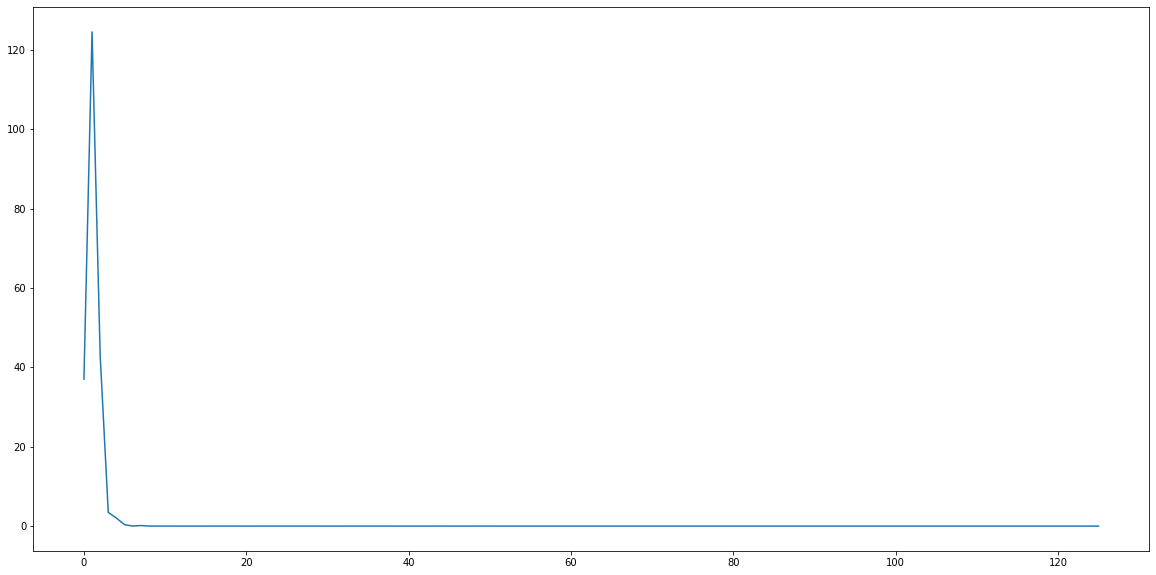

In [56]:
wel2 = welch(pleth_inp[0:250], 250)

plt.figure(figsize=(20,10))
#plt.plot(wel1[0],wel1[1])
plt.plot(wel2[0],wel2[1])

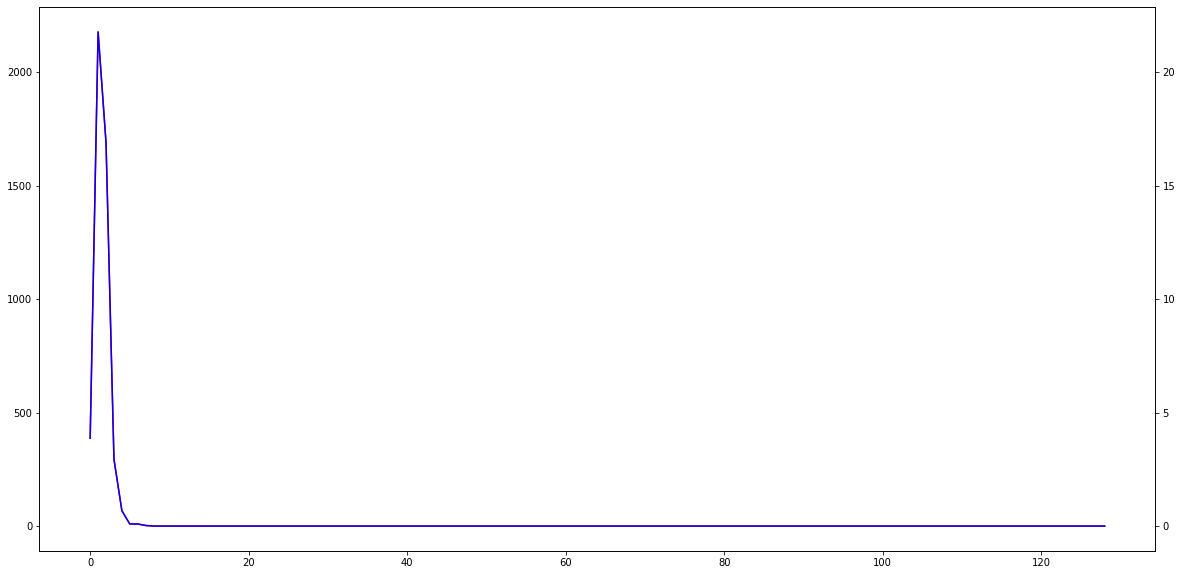

In [52]:
wel1 = welch(pleth_inp, 10)
wel2 = welch(pleth_inp, 250)
wel3 = welch(pleth_inp, 1000)

fig, ax = plt.subplots(figsize=(20,10))
ax2 = ax.twinx()

ax.plot(wel1[1], 'r')
ax2.plot(wel3[1], 'b')

## preop

In [61]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

non_preop_list = []


input_path = 'dataset/preprocess3/input3-2/welch/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if True:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/vital_data/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/preprocess3/input3/df_preprocess_preop','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test', 'rb'))
    caseid_train = pickle.load(open('caseid_train', 'rb'))
    caseid_val = pickle.load(open('caseid_val', 'rb'))
    

    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []
    x_val_preop,y_val_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        
        # vital data - ECG (250Hz)       
        try:
            ecg_samp = pickle.load(open(preop_ecg_path+row['file_path'].split(',')[2], 'rb'))
            
        except:
            non_preop_list.append(row['file_path'])
            print('no preop data')
            continue
        else:
            ecg_samp = pd.DataFrame(ecg_samp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]       
            ecg_per_NRS = np.full(30000,np.nan)
            ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
            
            # 한 NRS에 대해 23개의 input 확인
            for i in range(30,51):
                # input이 전처리 통과한 경우
                if row[str(i+1)]:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                    # input의 normalization
                    pleth_inp = ppg_per_NRS[start_idx:end_idx]
                    pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                    ecg_inp = ecg_per_NRS[start_idx:end_idx]
                    ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)


                    welch_ppg, welch_ecg = [], []
                    # 1초맏 welch 적용
                    for j in range(LEN_INPUT):
                        welch_ppg.append(welch(pleth_inp[j*250:(j+1)*250],SRATE)[1])
                        welch_ecg.append(welch(ecg_inp[j*250:(j+1)*250],SRATE)[1])


                    # 해당 caseid가 test set에 속하는 경우
                    if row['caseids'] in caseid_test:
                        x_test_preop.append([welch_ppg, welch_ecg])
                        y_test_preop.append(int(float(row['NRS'])))

                    # 해당 caseid가 train set에 해당하는 경우
                    elif row['caseids'] in caseid_val:
                        x_val_preop.append([welch_ppg, welch_ecg])
                        y_val_preop.append(int(float(row['NRS'])))

                    else:
                        x_train_preop.append([welch_ppg, welch_ecg])
                        y_train_preop.append(int(float(row['NRS'])))

            print('completed')


    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    x_val_preop = np.array(x_val_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)
    y_val_preop = np.array(y_val_preop, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'x_val_preop.npz', x_val_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    np.savez_compressed(input_path+'y_val_preop.npz', y_val_preop)
    print('done', flush=True)

    
    
    
print('size of training set(preop):', len(x_train_preop))
print('size of validation set(preop):', len(x_val_preop))
print('size of test set(preop):', len(x_test_preop))

loading data 1/3879 ...completed
loading data 2/3879 ...completed
loading data 3/3879 ...completed
loading data 4/3879 ...completed
loading data 5/3879 ...completed
loading data 6/3879 ...completed
loading data 7/3879 ...completed
loading data 8/3879 ...completed
loading data 9/3879 ...completed
loading data 10/3879 ...completed
loading data 11/3879 ...completed
loading data 12/3879 ...completed
loading data 13/3879 ...completed
loading data 14/3879 ...completed
loading data 15/3879 ...completed
loading data 16/3879 ...completed
loading data 17/3879 ...completed
loading data 18/3879 ...completed
loading data 19/3879 ...completed
loading data 20/3879 ...completed
loading data 21/3879 ...completed
loading data 22/3879 ...completed
loading data 23/3879 ...completed
loading data 24/3879 ...completed
loading data 25/3879 ...completed
loading data 26/3879 ...completed
loading data 27/3879 ...completed
loading data 28/3879 ...completed
loading data 29/3879 ...completed
loading data 30/3879 ..

loading data 240/3879 ...completed
loading data 241/3879 ...completed
loading data 242/3879 ...completed
loading data 243/3879 ...completed
loading data 244/3879 ...completed
loading data 245/3879 ...completed
loading data 246/3879 ...completed
loading data 247/3879 ...completed
loading data 248/3879 ...completed
loading data 249/3879 ...completed
loading data 250/3879 ...completed
loading data 251/3879 ...completed
loading data 252/3879 ...completed
loading data 253/3879 ...completed
loading data 254/3879 ...completed
loading data 255/3879 ...completed
loading data 256/3879 ...completed
loading data 257/3879 ...completed
loading data 258/3879 ...completed
loading data 259/3879 ...completed
loading data 260/3879 ...completed
loading data 261/3879 ...completed
loading data 262/3879 ...completed
loading data 263/3879 ...completed
loading data 264/3879 ...completed
loading data 265/3879 ...completed
loading data 266/3879 ...completed
loading data 267/3879 ...completed
loading data 268/387

loading data 477/3879 ...completed
loading data 478/3879 ...completed
loading data 479/3879 ...completed
loading data 480/3879 ...completed
loading data 481/3879 ...completed
loading data 482/3879 ...completed
loading data 483/3879 ...completed
loading data 484/3879 ...completed
loading data 485/3879 ...completed
loading data 486/3879 ...completed
loading data 487/3879 ...completed
loading data 488/3879 ...completed
loading data 489/3879 ...completed
loading data 490/3879 ...completed
loading data 491/3879 ...completed
loading data 492/3879 ...completed
loading data 493/3879 ...completed
loading data 494/3879 ...completed
loading data 495/3879 ...completed
loading data 496/3879 ...completed
loading data 497/3879 ...completed
loading data 498/3879 ...completed
loading data 499/3879 ...completed
loading data 500/3879 ...completed
loading data 501/3879 ...completed
loading data 502/3879 ...completed
loading data 503/3879 ...completed
loading data 504/3879 ...completed
loading data 505/387

loading data 718/3879 ...completed
loading data 719/3879 ...completed
loading data 720/3879 ...completed
loading data 721/3879 ...completed
loading data 722/3879 ...completed
loading data 723/3879 ...completed
loading data 724/3879 ...completed
loading data 725/3879 ...completed
loading data 726/3879 ...completed
loading data 727/3879 ...completed
loading data 728/3879 ...completed
loading data 729/3879 ...completed
loading data 730/3879 ...completed
loading data 731/3879 ...completed
loading data 732/3879 ...completed
loading data 733/3879 ...completed
loading data 734/3879 ...completed
loading data 735/3879 ...completed
loading data 736/3879 ...completed
loading data 737/3879 ...completed
loading data 738/3879 ...completed
loading data 739/3879 ...completed
loading data 740/3879 ...completed
loading data 741/3879 ...completed
loading data 742/3879 ...completed
loading data 743/3879 ...completed
loading data 744/3879 ...completed
loading data 745/3879 ...completed
loading data 746/387

loading data 954/3879 ...completed
loading data 955/3879 ...completed
loading data 956/3879 ...completed
loading data 957/3879 ...completed
loading data 958/3879 ...completed
loading data 959/3879 ...completed
loading data 960/3879 ...completed
loading data 961/3879 ...completed
loading data 962/3879 ...completed
loading data 963/3879 ...completed
loading data 964/3879 ...completed
loading data 965/3879 ...completed
loading data 966/3879 ...completed
loading data 967/3879 ...completed
loading data 968/3879 ...completed
loading data 969/3879 ...completed
loading data 970/3879 ...completed
loading data 971/3879 ...completed
loading data 972/3879 ...completed
loading data 973/3879 ...completed
loading data 974/3879 ...completed
loading data 975/3879 ...completed
loading data 976/3879 ...completed
loading data 977/3879 ...completed
loading data 978/3879 ...completed
loading data 979/3879 ...completed
loading data 980/3879 ...completed
loading data 981/3879 ...completed
loading data 982/387

loading data 1184/3879 ...completed
loading data 1185/3879 ...completed
loading data 1186/3879 ...completed
loading data 1187/3879 ...completed
loading data 1188/3879 ...completed
loading data 1189/3879 ...completed
loading data 1190/3879 ...completed
loading data 1191/3879 ...completed
loading data 1192/3879 ...completed
loading data 1193/3879 ...completed
loading data 1194/3879 ...completed
loading data 1195/3879 ...completed
loading data 1196/3879 ...completed
loading data 1197/3879 ...completed
loading data 1198/3879 ...completed
loading data 1199/3879 ...completed
loading data 1200/3879 ...completed
loading data 1201/3879 ...completed
loading data 1202/3879 ...completed
loading data 1203/3879 ...completed
loading data 1204/3879 ...completed
loading data 1205/3879 ...completed
loading data 1206/3879 ...completed
loading data 1207/3879 ...completed
loading data 1208/3879 ...completed
loading data 1209/3879 ...completed
loading data 1210/3879 ...completed
loading data 1211/3879 ...co

loading data 1411/3879 ...completed
loading data 1412/3879 ...completed
loading data 1413/3879 ...completed
loading data 1414/3879 ...completed
loading data 1415/3879 ...completed
loading data 1416/3879 ...completed
loading data 1417/3879 ...completed
loading data 1418/3879 ...completed
loading data 1419/3879 ...completed
loading data 1420/3879 ...completed
loading data 1421/3879 ...completed
loading data 1422/3879 ...completed
loading data 1423/3879 ...completed
loading data 1424/3879 ...completed
loading data 1425/3879 ...completed
loading data 1426/3879 ...completed
loading data 1427/3879 ...completed
loading data 1428/3879 ...completed
loading data 1429/3879 ...completed
loading data 1430/3879 ...completed
loading data 1431/3879 ...completed
loading data 1432/3879 ...completed
loading data 1433/3879 ...completed
loading data 1434/3879 ...completed
loading data 1435/3879 ...completed
loading data 1436/3879 ...completed
loading data 1437/3879 ...completed
loading data 1438/3879 ...co

loading data 1640/3879 ...completed
loading data 1641/3879 ...completed
loading data 1642/3879 ...completed
loading data 1643/3879 ...completed
loading data 1644/3879 ...completed
loading data 1645/3879 ...completed
loading data 1646/3879 ...completed
loading data 1647/3879 ...completed
loading data 1648/3879 ...completed
loading data 1649/3879 ...completed
loading data 1650/3879 ...completed
loading data 1651/3879 ...completed
loading data 1652/3879 ...completed
loading data 1653/3879 ...completed
loading data 1654/3879 ...completed
loading data 1655/3879 ...completed
loading data 1656/3879 ...completed
loading data 1657/3879 ...completed
loading data 1658/3879 ...completed
loading data 1659/3879 ...completed
loading data 1660/3879 ...completed
loading data 1661/3879 ...completed
loading data 1662/3879 ...completed
loading data 1663/3879 ...completed
loading data 1664/3879 ...completed
loading data 1665/3879 ...completed
loading data 1666/3879 ...completed
loading data 1667/3879 ...co

loading data 1868/3879 ...completed
loading data 1869/3879 ...completed
loading data 1870/3879 ...completed
loading data 1871/3879 ...completed
loading data 1872/3879 ...completed
loading data 1873/3879 ...completed
loading data 1874/3879 ...completed
loading data 1875/3879 ...completed
loading data 1876/3879 ...completed
loading data 1877/3879 ...completed
loading data 1878/3879 ...completed
loading data 1879/3879 ...completed
loading data 1880/3879 ...completed
loading data 1881/3879 ...completed
loading data 1882/3879 ...completed
loading data 1883/3879 ...completed
loading data 1884/3879 ...completed
loading data 1885/3879 ...completed
loading data 1886/3879 ...completed
loading data 1887/3879 ...completed
loading data 1888/3879 ...completed
loading data 1889/3879 ...completed
loading data 1890/3879 ...completed
loading data 1891/3879 ...completed
loading data 1892/3879 ...completed
loading data 1893/3879 ...completed
loading data 1894/3879 ...completed
loading data 1895/3879 ...co

loading data 2104/3879 ...completed
loading data 2105/3879 ...completed
loading data 2106/3879 ...completed
loading data 2107/3879 ...completed
loading data 2108/3879 ...completed
loading data 2109/3879 ...completed
loading data 2110/3879 ...completed
loading data 2111/3879 ...completed
loading data 2112/3879 ...completed
loading data 2113/3879 ...completed
loading data 2114/3879 ...completed
loading data 2115/3879 ...completed
loading data 2116/3879 ...completed
loading data 2117/3879 ...completed
loading data 2118/3879 ...completed
loading data 2119/3879 ...completed
loading data 2120/3879 ...completed
loading data 2121/3879 ...completed
loading data 2122/3879 ...completed
loading data 2123/3879 ...completed
loading data 2124/3879 ...completed
loading data 2125/3879 ...completed
loading data 2126/3879 ...completed
loading data 2127/3879 ...completed
loading data 2128/3879 ...completed
loading data 2129/3879 ...completed
loading data 2130/3879 ...completed
loading data 2131/3879 ...co

loading data 2331/3879 ...completed
loading data 2332/3879 ...completed
loading data 2333/3879 ...completed
loading data 2334/3879 ...completed
loading data 2335/3879 ...completed
loading data 2336/3879 ...completed
loading data 2337/3879 ...completed
loading data 2338/3879 ...completed
loading data 2339/3879 ...completed
loading data 2340/3879 ...completed
loading data 2341/3879 ...completed
loading data 2342/3879 ...completed
loading data 2343/3879 ...completed
loading data 2344/3879 ...completed
loading data 2345/3879 ...completed
loading data 2346/3879 ...completed
loading data 2347/3879 ...completed
loading data 2348/3879 ...completed
loading data 2349/3879 ...completed
loading data 2350/3879 ...completed
loading data 2351/3879 ...completed
loading data 2352/3879 ...completed
loading data 2353/3879 ...completed
loading data 2354/3879 ...completed
loading data 2355/3879 ...completed
loading data 2356/3879 ...completed
loading data 2357/3879 ...completed
loading data 2358/3879 ...co

loading data 2558/3879 ...completed
loading data 2559/3879 ...completed
loading data 2560/3879 ...completed
loading data 2561/3879 ...completed
loading data 2562/3879 ...completed
loading data 2563/3879 ...completed
loading data 2564/3879 ...completed
loading data 2565/3879 ...completed
loading data 2566/3879 ...completed
loading data 2567/3879 ...completed
loading data 2568/3879 ...completed
loading data 2569/3879 ...completed
loading data 2570/3879 ...completed
loading data 2571/3879 ...completed
loading data 2572/3879 ...completed
loading data 2573/3879 ...completed
loading data 2574/3879 ...completed
loading data 2575/3879 ...completed
loading data 2576/3879 ...completed
loading data 2577/3879 ...completed
loading data 2578/3879 ...completed
loading data 2579/3879 ...completed
loading data 2580/3879 ...completed
loading data 2581/3879 ...completed
loading data 2582/3879 ...completed
loading data 2583/3879 ...completed
loading data 2584/3879 ...completed
loading data 2585/3879 ...co

loading data 2788/3879 ...completed
loading data 2789/3879 ...completed
loading data 2790/3879 ...completed
loading data 2791/3879 ...completed
loading data 2792/3879 ...completed
loading data 2793/3879 ...completed
loading data 2794/3879 ...completed
loading data 2795/3879 ...completed
loading data 2796/3879 ...completed
loading data 2797/3879 ...completed
loading data 2798/3879 ...completed
loading data 2799/3879 ...completed
loading data 2800/3879 ...completed
loading data 2801/3879 ...completed
loading data 2802/3879 ...completed
loading data 2803/3879 ...completed
loading data 2804/3879 ...completed
loading data 2805/3879 ...completed
loading data 2806/3879 ...completed
loading data 2807/3879 ...completed
loading data 2808/3879 ...completed
loading data 2809/3879 ...completed
loading data 2810/3879 ...completed
loading data 2811/3879 ...completed
loading data 2812/3879 ...completed
loading data 2813/3879 ...completed
loading data 2814/3879 ...completed
loading data 2815/3879 ...co

loading data 3016/3879 ...completed
loading data 3017/3879 ...completed
loading data 3018/3879 ...completed
loading data 3019/3879 ...completed
loading data 3020/3879 ...completed
loading data 3021/3879 ...completed
loading data 3022/3879 ...completed
loading data 3023/3879 ...completed
loading data 3024/3879 ...completed
loading data 3025/3879 ...completed
loading data 3026/3879 ...completed
loading data 3027/3879 ...completed
loading data 3028/3879 ...completed
loading data 3029/3879 ...completed
loading data 3030/3879 ...completed
loading data 3031/3879 ...completed
loading data 3032/3879 ...completed
loading data 3033/3879 ...completed
loading data 3034/3879 ...completed
loading data 3035/3879 ...completed
loading data 3036/3879 ...completed
loading data 3037/3879 ...completed
loading data 3038/3879 ...completed
loading data 3039/3879 ...completed
loading data 3040/3879 ...completed
loading data 3041/3879 ...completed
loading data 3042/3879 ...completed
loading data 3043/3879 ...co

loading data 3244/3879 ...completed
loading data 3245/3879 ...completed
loading data 3246/3879 ...completed
loading data 3247/3879 ...completed
loading data 3248/3879 ...completed
loading data 3249/3879 ...completed
loading data 3250/3879 ...completed
loading data 3251/3879 ...completed
loading data 3252/3879 ...completed
loading data 3253/3879 ...completed
loading data 3254/3879 ...completed
loading data 3255/3879 ...completed
loading data 3256/3879 ...completed
loading data 3257/3879 ...completed
loading data 3258/3879 ...completed
loading data 3259/3879 ...completed
loading data 3260/3879 ...completed
loading data 3261/3879 ...completed
loading data 3262/3879 ...completed
loading data 3263/3879 ...completed
loading data 3264/3879 ...completed
loading data 3265/3879 ...completed
loading data 3266/3879 ...completed
loading data 3267/3879 ...completed
loading data 3268/3879 ...completed
loading data 3269/3879 ...completed
loading data 3270/3879 ...completed
loading data 3271/3879 ...co

loading data 3471/3879 ...completed
loading data 3472/3879 ...completed
loading data 3473/3879 ...completed
loading data 3474/3879 ...completed
loading data 3475/3879 ...completed
loading data 3476/3879 ...completed
loading data 3477/3879 ...completed
loading data 3478/3879 ...completed
loading data 3479/3879 ...completed
loading data 3480/3879 ...completed
loading data 3481/3879 ...completed
loading data 3482/3879 ...completed
loading data 3483/3879 ...completed
loading data 3484/3879 ...completed
loading data 3485/3879 ...completed
loading data 3486/3879 ...completed
loading data 3487/3879 ...completed
loading data 3488/3879 ...completed
loading data 3489/3879 ...completed
loading data 3490/3879 ...completed
loading data 3491/3879 ...completed
loading data 3492/3879 ...completed
loading data 3493/3879 ...completed
loading data 3494/3879 ...completed
loading data 3495/3879 ...completed
loading data 3496/3879 ...completed
loading data 3497/3879 ...completed
loading data 3498/3879 ...co

loading data 3702/3879 ...completed
loading data 3703/3879 ...completed
loading data 3704/3879 ...completed
loading data 3705/3879 ...completed
loading data 3706/3879 ...completed
loading data 3707/3879 ...completed
loading data 3708/3879 ...completed
loading data 3709/3879 ...completed
loading data 3710/3879 ...completed
loading data 3711/3879 ...completed
loading data 3712/3879 ...completed
loading data 3713/3879 ...completed
loading data 3714/3879 ...completed
loading data 3715/3879 ...completed
loading data 3716/3879 ...completed
loading data 3717/3879 ...completed
loading data 3718/3879 ...completed
loading data 3719/3879 ...completed
loading data 3720/3879 ...completed
loading data 3721/3879 ...completed
loading data 3722/3879 ...completed
loading data 3723/3879 ...completed
loading data 3724/3879 ...completed
loading data 3725/3879 ...completed
loading data 3726/3879 ...completed
loading data 3727/3879 ...completed
loading data 3728/3879 ...completed
loading data 3729/3879 ...co

## pacu + preop

In [95]:
input_path = 'dataset/preprocess3/input3-2/welch/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
x_val_pacu = np.load(input_path+'x_val_pacu.npz', allow_pickle=True)['arr_0']
y_val_pacu = np.load(input_path+'y_val_pacu.npz')['arr_0']
print('done', flush=True)

print('x_train_pacu shape:', x_train_pacu.shape)
print('x_val_pacu shape:', x_val_pacu.shape)
print('x_test_pacu shape:', x_test_pacu.shape)


# loading preop
print('loading preop data...', flush=True, end='')
x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
x_val_preop = np.load(input_path+'x_val_preop.npz', allow_pickle=True)['arr_0']
y_val_preop = np.load(input_path+'y_val_preop.npz')['arr_0']
print('done', flush=True)

print('x_train_preop shape:', x_train_preop.shape)
print('x_val_preop shape:', x_val_preop.shape)
print('x_test_preop shape:', x_test_preop.shape)


# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)
x_val = np.concatenate((x_val_pacu, x_val_preop), axis = 0)
y_val = np.concatenate((y_val_pacu, y_val_preop), axis = 0)


# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,3,1])
x_val = np.transpose(x_val, [0,2,3,1])
x_test = np.transpose(x_test, [0,2,3,1])

print('after concatenate + transpose')
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)



# filling nan
x_train2 = np.ones(shape=x_train.shape)
for idx, x in enumerate(x_train):
    x_train2[idx,:,:,0] = pd.DataFrame(x[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
    x_train2[idx,:,:,1] = pd.DataFrame(x[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values


x_val2 = np.ones(shape=x_val.shape)
for idx, x in enumerate(x_val):
    x_val2[idx,:,:,0] = pd.DataFrame(x[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
    x_val2[idx,:,:,1] = pd.DataFrame(x[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

    
x_test2 = np.ones(shape=x_test.shape)
for idx, x in enumerate(x_test):
    x_test2[idx,:,:,0] = pd.DataFrame(x[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
    x_test2[idx,:,:,1] = pd.DataFrame(x[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
 

y_train_bin = y_train>=4
y_test_bin = y_test>=4
print('train {} ({} events {:.1f}%), test {} (events {:.2f}%)'.format(len(y_train_bin), sum(y_train_bin), 100*np.mean(y_train_bin), len(x_test), 100*np.mean(y_test_bin)))


# 저장하기 - completed train, test set
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train2)
np.savez_compressed(input_path+'x_test.npz', x_test2)
np.savez_compressed(input_path+'x_val.npz', x_val2)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
np.savez_compressed(input_path+'y_val.npz', y_val)
print('done', flush=True)

loading pacu data...done
x_train_pacu shape: (63700, 2, 20, 126)
x_val_pacu shape: (7057, 2, 20, 126)
x_test_pacu shape: (7617, 2, 20, 126)
loading preop data...done
x_train_preop shape: (14813, 2, 20, 126)
x_val_preop shape: (1650, 2, 20, 126)
x_test_preop shape: (1727, 2, 20, 126)
after concatenate + transpose
x_train shape: (78513, 20, 126, 2)
x_val shape: (8707, 20, 126, 2)
x_test shape: (9344, 20, 126, 2)
train 78513 (48381 events 61.6%), test 9344 (events 57.76%)
saving...done


In [90]:
np.sum(np.isnan(x_train)), x_train2.shape, np.sum(np.isnan(x_train2))

(4284, (78513, 126, 2, 20), 0)

# Settings

## Loading input

In [ ]:
import pandas as pd

print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
input_path = '../DL_model/dataset/preprocess3/input3-2/welch/'
x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
x_val = np.load(input_path+'x_val.npz', allow_pickle=True)['arr_0']

y_train = np.load(input_path+'y_train.npz')['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']
y_val = np.load(input_path+'y_val.npz')['arr_0']
print('done', flush=True)

print('x_train shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('x_val.shape:', x_val.shape)

In [101]:
x_train_ppg = x_train[:,:,:,0]
x_val_ppg = x_val[:,:,:,0]
x_test_ppg = x_test[:,:,:,0]

x_train_ecg = x_train[:,:,:,1]
x_val_ecg = x_val[:,:,:,1]
x_test_ecg = x_test[:,:,:,1]

## Label

In [99]:
# binary classification
y_train_bin = y_train >= 4
y_test_bin = y_test >= 4
y_val_bin = y_val >= 4

y_train_bin2 = y_train >=7
y_val_bin2 = y_val>=7
y_test_bin2 = y_test>=7

## GPU settings

In [97]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 4 Logical GPUs


## class weights

### 2 class

In [100]:
# 2 class에 대한 sample weight
train_w_samp2 = np.ones(shape=(len(y_train),))
train_w_samp2[y_train_bin==0]= len(y_train) / np.sum(y_train_bin)
train_w_samp2[y_train_bin!=0]= len(y_train) / np.sum(~y_train_bin)

train_w_samp2_2 = np.ones(shape=(len(y_train),))
train_w_samp2_2[y_train_bin==0]= len(y_train) / np.sum(y_train_bin2)
train_w_samp2_2[y_train_bin!=0]= len(y_train) / np.sum(~y_train_bin2)

print('sample weight for no pain: {:.2f}, moderate pain: {:.2f}'
      .format(len(y_train) / np.sum(y_train_bin), len(y_train) / np.sum(~y_train_bin)))
print('sample weight for no pain: {:.2f}, severe pain: {:.2f}'
      .format(len(y_train) / np.sum(y_train_bin2), len(y_train) / np.sum(~y_train_bin2)))

# 2 class에 대한 sample weight
val_w_samp2 = np.ones(shape=(len(y_val),))
val_w_samp2[y_val_bin==0]= len(y_val) / np.sum(y_val_bin)
val_w_samp2[y_val_bin!=0]= len(y_val) / np.sum(~y_val_bin)

val_w_samp2_2 = np.ones(shape=(len(y_val),))
val_w_samp2_2[y_val_bin==0]= len(y_val) / np.sum(y_val_bin2)
val_w_samp2_2[y_val_bin!=0]= len(y_val) / np.sum(~y_val_bin2)

print('sample weight for no pain: {:.2f}, moderate pain: {:.2f}'
      .format(len(y_val) / np.sum(y_val_bin), len(y_val) / np.sum(~y_val_bin)))
print('sample weight for no pain: {:.2f}, severe pain: {:.2f}'
      .format(len(y_val) / np.sum(y_val_bin2), len(y_val) / np.sum(~y_val_bin2)))

# 2 class에 대한 sample weight
test_w_samp2 = np.ones(shape=(len(y_test),))
test_w_samp2[y_test_bin==0]= len(y_test) / np.sum(y_test_bin)
test_w_samp2[y_test_bin!=0]= len(y_test) / np.sum(~y_test_bin)

test_w_samp2_2 = np.ones(shape=(len(y_test),))
test_w_samp2_2[y_test_bin==0]= len(y_test) / np.sum(y_test_bin2)
test_w_samp2_2[y_test_bin!=0]= len(y_test) / np.sum(~y_test_bin2)

print('sample weight for no pain: {:.2f}, moderate pain: {:.2f}'
      .format(len(y_test) / np.sum(y_test_bin), len(y_test) / np.sum(~y_test_bin)))
print('sample weight for no pain: {:.2f}, severe pain: {:.2f}'
      .format(len(y_test) / np.sum(y_test_bin2), len(y_test) / np.sum(~y_test_bin2)))

sample weight for no pain: 1.62, moderate pain: 2.61
sample weight for no pain: 6.40, severe pain: 1.19
sample weight for no pain: 1.60, moderate pain: 2.68
sample weight for no pain: 6.86, severe pain: 1.17
sample weight for no pain: 1.73, moderate pain: 2.37
sample weight for no pain: 6.76, severe pain: 1.17


### 3 class

In [ ]:
# 3 class에 대한 sample weight
train_w_samp3 = np.ones(shape=(len(y_train),))

train_w_samp3[y_train<4]= len(y_train)/np.sum(y_train<4)
train_w_samp3[(y_train>=4)&(y_train<7)]= len(y_train)/np.sum((4<=y_train)&(y_train<7))
train_w_samp3[y_train>=7]= len(y_train)/np.sum(y_train>=7)


print('sample weight for class 1: {:.2f}, class 2: {:.2f}, class 3: {:.2f}'
      .format(len(y_train)/np.sum(y_train<4),len(y_train)/np.sum((y_train>=4)&(y_train<7)),len(y_train)/np.sum(y_train>=7)))

# 3 class에 대한 sample weight
val_w_samp3 = np.ones(shape=(len(y_val),))

val_w_samp3[y_val<4]= len(y_val)/np.sum(y_val<4)
val_w_samp3[(y_val>=4)&(y_val<7)]= len(y_val)/np.sum((4<=y_val)&(y_val<7))
val_w_samp3[y_val>=7]= len(y_val)/np.sum(y_val>=7)


print('sample weight for class 1: {:.2f}, class 2: {:.2f}, class 3: {:.2f}'
      .format(len(y_val)/np.sum(y_val<4),len(y_val)/np.sum((y_val>=4)&(y_val<7)),len(y_val)/np.sum(y_val>=7)))

# 3 class에 대한 sample weight
test_w_samp3 = np.ones(shape=(len(y_test),))

test_w_samp3[y_test<4]= len(y_test)/np.sum(y_test<4)
test_w_samp3[(y_test>=4)&(y_test<7)]= len(y_test)/np.sum((4<=y_test)&(y_test<7))
test_w_samp3[y_test>=7]= len(y_test)/np.sum(y_test>=7)


print('sample weight for class 1: {:.2f}, class 2: {:.2f}, class 3: {:.2f}'
      .format(len(y_test)/np.sum(y_test<4),len(y_test)/np.sum((y_test>=4)&(y_test<7)),len(y_test)/np.sum(y_test>=7)))

# Training

In [ ]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, LeakyReLU
from keras.layers import Input, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K
from keras import regularizers
from keras.initializers import he_normal, GlorotNormal
import tensorflow_addons as tfa

# hyperparamters
nlayer = 1
units = [64, 64, 64, 64]

BATCH_SIZE = 1024
dense_node = 16
dropout1 = 0.2
dropout2 = 0.2
learning_rate = 0.001


# initializer & regularizer
k_init = he_normal(seed=None)
#k_init = GlorotNormal(seed=None) # Xavier normal initializer
#k_init = None
b_init = None
k_l2 = 0
#k_reg = regularizers.l2(l2=k_l2)
k_reg = None
b_reg = None


testname = '-'.join([str(unit) for unit in units])
print(testname)


# 출력 폴더를 생성
model_name = 'model_bin_sampleweight2_'
for unit in units:
    model_name += 'unit{}_'.format(unit)
model_name += 'nlayer{}_dropout{}_dense{}_dropout{}'.format(len(units), dropout1, dense_node, dropout2)

#model_name = 'model_reg_{}_{}_{}_size{}_relu_bn_maxpool{}_globalmaxpool_dense32_dropout{}_batch{}_learning_rate{}'.format(num_nodes[0], num_nodes[1], num_nodes[2], kernel_size, pool_size, dropout_rate, BATCH_SIZE, learning_rate)
save_path = "output/preprocess3/input3-2_PPG+ECG/LSTM_"+model_name

if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"


# GPU 설정
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2","/gpu:3"])
with strategy.scope():
    '''
    # build a model - sequential
    model = Sequential()
    
    #model.add(LSTM(unit= 4, input_shape=(20,126)))
    for unit in units:
        model.add(LSTM(unit))
    

    #model.add(Dense(dense_node, activation='tanh', kernel_initializer=k_init, kernel_regularizer=k_reg))
    model.add(Dropout(dropout1))
    model.add(Dense(1, activation='sigmoid'))
    '''
    

    # build a model - function api
    inp = Input(shape=(x_train.shape[1], x_train.shape[2]))
    
    # lstm layer
    inp_lstm = inp
    for unit in units[:-1]:
        inp_lstm = LSTM(unit, return_sequences=True) (inp_lstm)
    out_lstm = LSTM(units[-1]) (inp_lstm)
    
    
    out_lstm = Dropout(dropout1) (out_lstm)
    
    if dense_node != 0:
        out_lstm = Dense(dense_node, activation='tanh') (out_lstm)
        out_lstm = Dropout(dropout2) (out_lstm)
    
    # output
    out = Dense(1, activation='sigmoid') (out_lstm)
    model = Model(inputs=[inp], outputs=[out])
    
    #print(abc)
    # model 학습 설정
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
    hist = model.fit(x_train_ppg, y_train_bin, validation_data = (x_val_ppg, y_val_bin, val_w_samp2), sample_weight=train_w_samp2, epochs=100, batch_size=BATCH_SIZE, #class_weight={0:1, 1:3}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='auto')])

    
model.load_weights(weight_path)
    
# 모델의 아키텍처 및 구조 저장
open(save_path + "/model.json", "wt").write(model.to_json())


# 전체 test 샘플을 한번에 예측
y_pred = model.predict(x_test_ppg).flatten() # binary는 flatten

# 결과를 저장
#np.savetxt(save_path+'/pred_y.txt', y_pred)


# 모델의 history log 저장 - binary classification
for key in hist.history.keys():
    if 'auc' in key and not 'val' in key:
        auc_key = key
#pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['accuracy'], hist.history['val_accuracy'], hist.history[auc], hist.history['val_'+auc]), open(save_path+'/history', 'wb'))

# 모델의 history log 저장 - regression
pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['acc'], hist.history['val_acc'], hist.history[auc_key], hist.history['val_'+auc_key]), open(save_path+'/history', 'wb'))


64-64-64-64
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Epoch 1/100


In [134]:
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 20, 126)]         0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 20, 64)            48896     
_________________________________________________________________
lstm_15 (LSTM)               (None, 20, 64)            33024     
_________________________________________________________________
lstm_16 (LSTM)               (None, 20, 64)            33024     
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)              

## training history

model: model_bin_sampleweight2_unit64_unit64_unit64_unit64_nlayer4_dropout0.2_dense16_dropout0.2


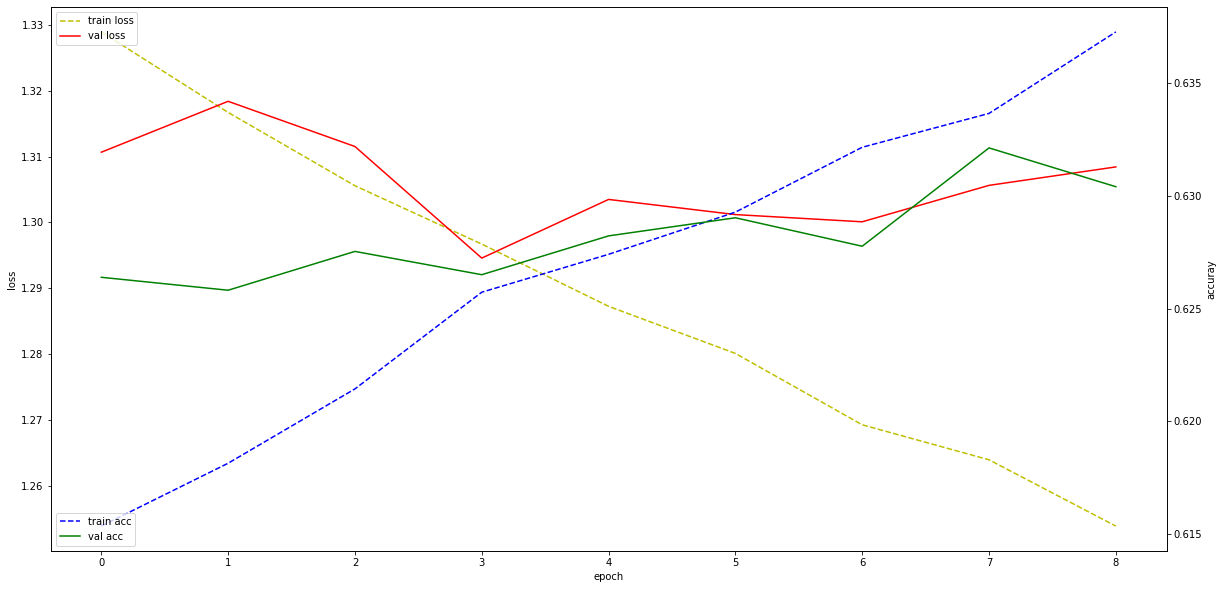

In [135]:
%matplotlib inline
import matplotlib.pyplot as plt


print('model:', model_name)


fig, loss_ax = plt.subplots(figsize=(20,10))

#x-axis는 공유하지만 y-axis는 공유x
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', linestyle='dashed', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

#acc_ax.plot(hist.history['mean_absolute_error'], 'b', linestyle='dashed',label='train mae')
#acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val mae')
acc_ax.plot(hist.history['acc'], 'b', linestyle='dashed',label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylim(0.2,1.0)
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# Evaluation

## AUROC, AUPRC

test set accuracy:0.65
test set AUROC: 0.5661496907397245
test set AUPRC: 0.691820954765959


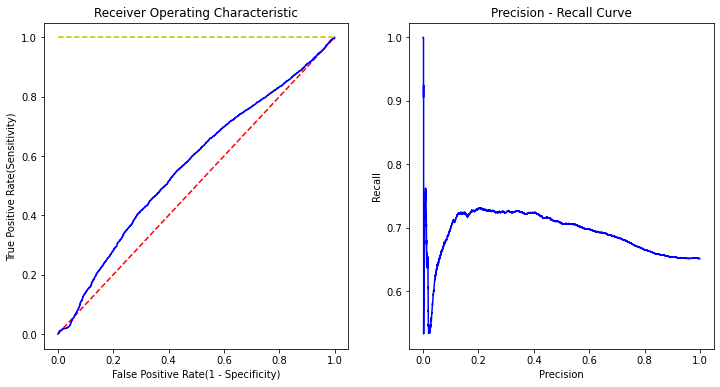

In [136]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

### Classification
# Model Accuracy of test set
#model_y = y_pred>=0.5
#acc_val = np.mean(model_y==y_test_bin)
acc = metrics.Accuracy()
acc.update_state(y_pred>=0.5, y_test_bin, sample_weight=test_w_samp2)
acc_val = acc.result().numpy()
print('test set accuracy:{:.2f}'.format(acc_val))


# moderate pain
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred, sample_weight = test_w_samp2)
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred, sample_weight = test_w_samp2)
roc_auc = auc(false_positive_rate, true_positive_rate)
prc_auc = auc(recall, precision)
print('test set AUROC:', roc_auc)
print('test set AUPRC:', prc_auc)


# Adding evaluation results to file name
test_path = 'output/preprocess3/input3-2_PPG+ECG/auroc{:.4f}_auprc{:.4f}_{}acc{:.2f}'.format(roc_auc,prc_auc,model_name,acc_val)
os.rename(save_path, test_path)

# Plotting ROC, PRC
fig = plt.figure(figsize=(12,6))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.plot(false_positive_rate, true_positive_rate, 'b', label='moderate pain (AUC = %0.4f)'% roc_auc)

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - Recall Curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall, precision, 'b', label='moderate pain (AUC = %0.4f)'% prc_auc)

plt.savefig(test_path + '/roc_prc.png', bbox_inches="tight", pad_inches=0.5)
